In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

In [104]:
# Parameters

UNITS_IN = 64
UNITS_H1 = 5
UNITS_H2 = 5
UNITS_OUT = 10
LR = 0.1
BATCH_SIZE = 64
NEPOCHS = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [105]:
# Prepare data

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

data = load_digits()
X, y = data.data, data.target
X = (X / 16).astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

class MyDataset(Dataset):
    
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        X = torch.from_numpy(self.X[idx])
        y = torch.tensor(self.y[idx])
        return X, y
    
train_ds = MyDataset(X_train, y_train)
test_ds = MyDataset(X_test, y_test)
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=256)

Xb, yb = next(iter(train_dl))
print(Xb.shape, yb.shape)

torch.Size([64, 64]) torch.Size([64])


In [106]:
# Build model

class Model(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(UNITS_IN, UNITS_H1)
        self.fc2 = nn.Linear(UNITS_H1, UNITS_H2)
        self.fc3 = nn.Linear(UNITS_H2, UNITS_OUT)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
model = Model().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=LR)

Xb, yb = next(iter(train_dl))
logits = model(Xb.to(device))
loss = criterion(logits, yb.to(device))
print(loss.item())

2.335399866104126


In [107]:
def run_epoch(model, data, criterion, optimizer=None):
    
    run_loss = 0
    corr = 0
    
    model.train(optimizer is not None)
    
    for xb, yb in data:
        xb, yb = xb.to(device), yb.to(device)
        
        with torch.set_grad_enabled(optimizer is not None):
        
            if optimizer is not None:
                optimizer.zero_grad()
        
            logits = model(xb)
            preds = torch.argmax(logits, 1)
            loss = criterion(logits, yb)
            run_loss += loss.item() * len(xb)
            corr += (preds == yb).sum().item()
            
            if optimizer is not None:
                loss.backward()
                optimizer.step()
        
        
        
        
    return run_loss / len(data.dataset), corr / len(data.dataset)


train_losses, train_accs, test_losses, test_accs = [], [], [], []

for epoch in range(NEPOCHS):
    
    train_loss, train_acc = run_epoch(model, train_dl, criterion,
                                      optimizer)
    test_loss, test_acc = run_epoch(model, test_dl, criterion)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)
    
    if (epoch + 1) % 10 == 0:
        print(('Epoch {}/{}: train_loss = {:.4f}, train_acc = {:.2f}%'
              + 'test_loss = {:.4f}, test_acc = {:.2f}%').format(
              epoch+1, NEPOCHS, train_loss, train_acc*100,
              test_loss, test_acc*100))

Epoch 10/200: train_loss = 1.9838, train_acc = 31.52%test_loss = 1.9576, test_acc = 31.11%
Epoch 20/200: train_loss = 1.2455, train_acc = 53.17%test_loss = 1.2054, test_acc = 52.78%
Epoch 30/200: train_loss = 0.7406, train_acc = 74.67%test_loss = 0.7169, test_acc = 76.39%
Epoch 40/200: train_loss = 0.5671, train_acc = 80.38%test_loss = 0.5765, test_acc = 80.56%
Epoch 50/200: train_loss = 0.4422, train_acc = 84.69%test_loss = 0.5014, test_acc = 83.06%
Epoch 60/200: train_loss = 0.3848, train_acc = 86.64%test_loss = 0.4552, test_acc = 85.00%
Epoch 70/200: train_loss = 0.3187, train_acc = 89.42%test_loss = 0.3626, test_acc = 89.44%
Epoch 80/200: train_loss = 0.2895, train_acc = 91.16%test_loss = 0.3827, test_acc = 88.33%
Epoch 90/200: train_loss = 0.2755, train_acc = 91.37%test_loss = 0.3577, test_acc = 86.67%
Epoch 100/200: train_loss = 0.2674, train_acc = 92.21%test_loss = 0.2938, test_acc = 91.11%
Epoch 110/200: train_loss = 0.2319, train_acc = 93.25%test_loss = 0.2581, test_acc = 91.9

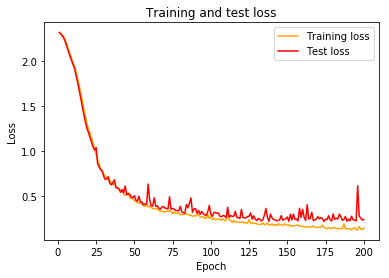

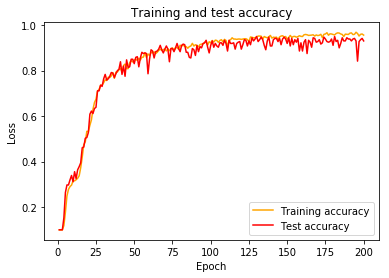

In [108]:
epochs = range(1, NEPOCHS+1)

plt.plot(epochs, train_losses, c='orange', label='Training loss')
plt.plot(epochs, test_losses, c='red', label='Test loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test loss')
plt.legend()
plt.show()

plt.plot(epochs, train_accs, c='orange', label='Training accuracy')
plt.plot(epochs, test_accs, c='red', label='Test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and test accuracy')
plt.legend()
plt.show()